## SARIMA Justification

- The strong autocorrelation for the room occupancy time series, suggest an autoregressive model such as ARMA or ARIMA or SARIMA
- The occupancy history is non-stationary and there is an upward trend, so the integrated component of ARIMA will automatically perform the differencing needed to transform the data into stationary data. So preferable to ARMA
- The strong seasonality suggests SARIMA would be most appropriate as it can process seasonal patterns. So preferable to ARIMA

SARIMA
- nb to be clear SARIMA stands for Seasonal Autoregressive Integrated Moving Average
- S: seasonal component, here handle the annual occupancy seasonality
- AR: autoregressive component .... p
- I: integrated, here handle the positive historical trend through differencing to make it stationary .... d
- MA: moving average component ...... q
- SARIMA(p,d,q)(P,D,Q),m
- p,d,q non-seasonal
- P,D,Q seasonal
- m the seasonality period, length of the seasonal cycle
- !! But this is daily, with an annual cycle so would be m=365 which is too large ??

Residuals .... ??
- Residuals plot
- ACF plot of residuals
- Durbin-Watson of residuals .... ?? be close to 2


Approach
- Confirm/Assess the autoregressive order (AR, p) and moving average order (MA, q). Using PACF plot and ACF plot respectively [repeat autocorrelation findings from previously?]
- Use the SARIMA(p,d,q)(P,D,Q,m) model
- Identify the best parameters using Auto Arima and using AIC (Akaike Information Criterion) to compare

- ?? daily 365d is too much
- ?? First evaluate using residuals ....

- Split data and use 3 years history to the train the model, then 1 year to evaluate its accuracy
- ??? Use accuracy measures MAE, RMSE, MAPE ....

Forecasting With model
- Make month forecast and demonstrate its use in the revenue/occupancy spreadsheet


## Data Load & Model Factors

- Load time series data
- Assess the autoregressive order (AR, p) - Using PACF plot
- Assess moving average order (MA, q) - Using ACF plot 


In [28]:
# Libraries
#

import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, pacf_ols
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm

import pmdarima as pm

import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from pandas.plotting import lag_plot


In [29]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [30]:
# Load the time series CSV
#

# Load the states .csv file, exit if do not exist or are invalid
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')
hotel_time_series_df = pd.read_csv(file_path, parse_dates=['Date'])
hotel_time_series_df.set_index('Date', inplace=True)

# Tidy Up
del file_name, file_path

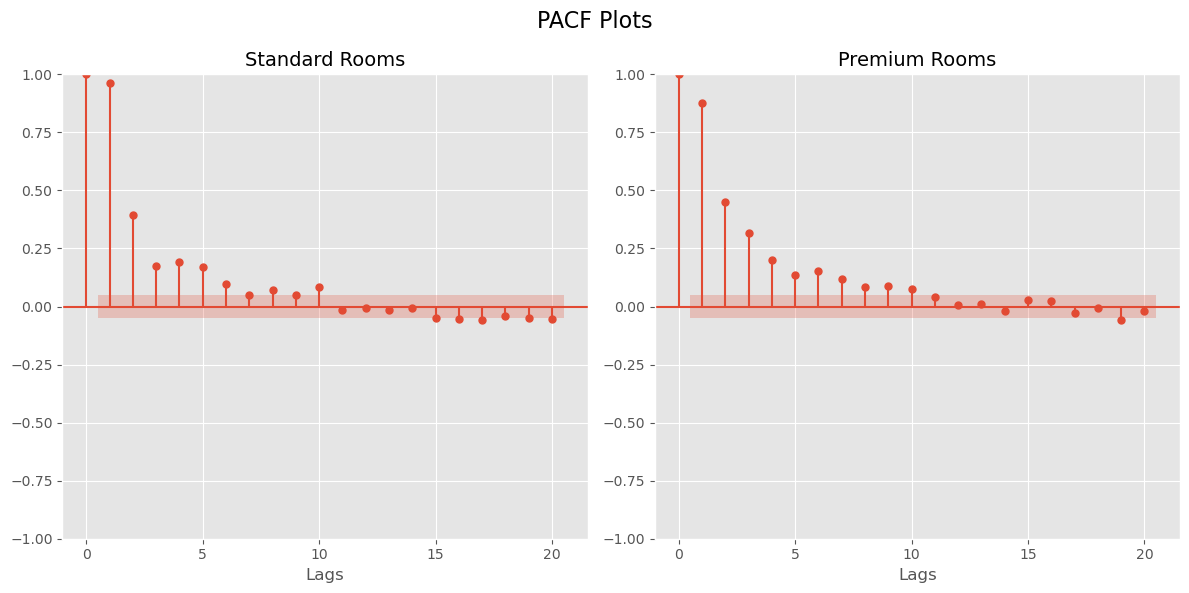

In [31]:
# Assess the autoregressive order (AR, p) - Using PACF plot
#

lag_value = 20

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('PACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_pacf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=14)
ax1.set_xlabel('Lags', fontsize=12)
#ax1.set_ylabel('PACF', fontsize=12)

# Plot for Premium Rooms
plot_pacf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=14)
ax2.set_xlabel('Lags', fontsize=12)
#ax2.set_ylabel('PACF', fontsize=12)

plt.tight_layout()
plt.show()

PACF plot suggests AR order, p of approximately 3

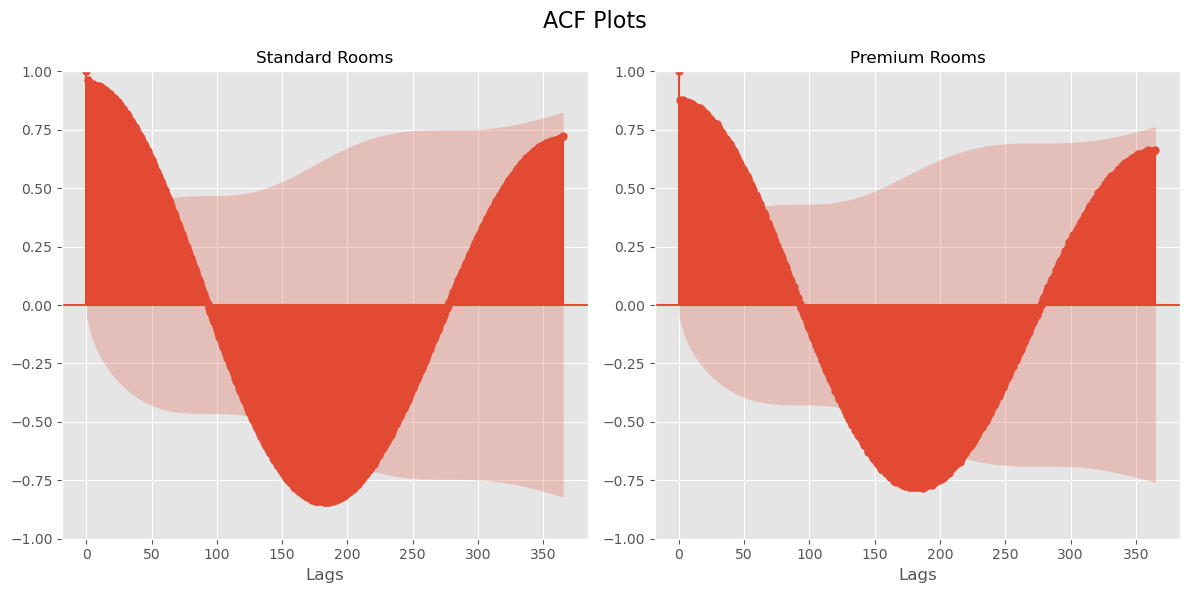

In [32]:
# Assess moving average order (MA, q) - Using ACF plot
#

lag_value = 365

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('ACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_acf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=12)
ax1.set_xlabel('Lags', fontsize=12)

# Plot for Premium Rooms
plot_acf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=12)
ax2.set_xlabel('Lags', fontsize=12)

plt.tight_layout()
plt.show()

ACF plot suggests MA order q of approximately 60

## Create the SARIMA Model

- Save the training dataset to be used to train a SARIMA model, in a separate notebook
- Load the model in here for forecasting


In [34]:
# Define the training and evaluation datasets, save for separate SARIMA model creation

# Daily data, with set aside  for testing
historical_data = hotel_time_series_df['Standard_OCC'][:]

forecast_horizon = 365 # Reserve the last 365 days, 1 year for testing
training_data = historical_data[:-forecast_horizon]
testing_data = historical_data[-forecast_horizon:]

# Save the training & testing data for separate model training
%store training_data testing_data


Stored 'training_data' (Series)
Stored 'testing_data' (Series)


In [11]:
# Load a saved SARIMA model that was created in a separate notebook
# Due to the length of time needed to create the model and avoid rerunning

%store -r model_sarima_manual


## Evaluate the Model Predictions

- Compare actual to the predictions for the testing data

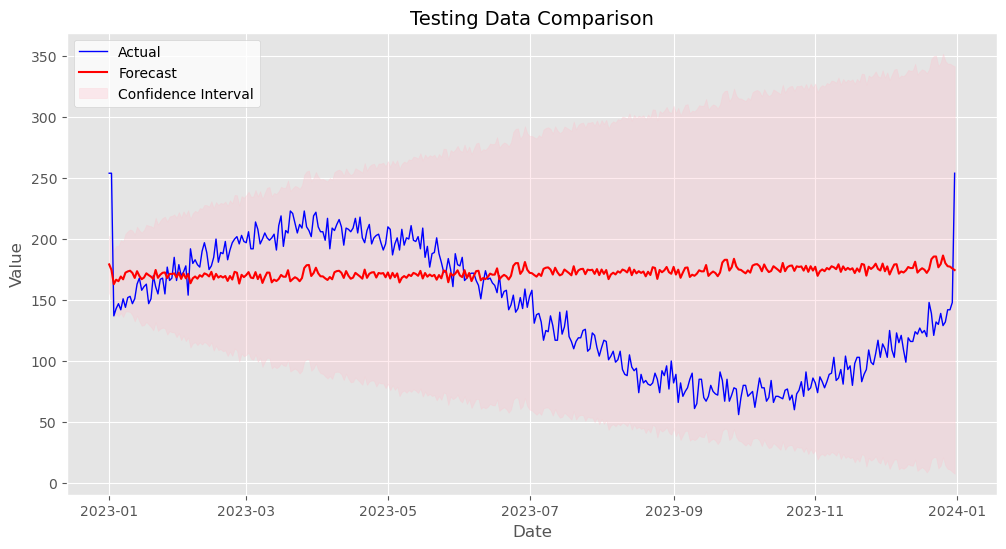

RMSE is: 50.94


In [26]:
# Create forecast using the testing dataset & compare to the actual values
#

# Actual values for the testing data
actual = testing_data

# Create predictions for the same length of time as the testing data
forecast = model_sarima_manual.get_prediction(start=testing_data.index[0], end=testing_data.index[-1])
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the actuals, forecast and confidence intervals
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title(f'Testing Data Comparison', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
# Three line plots
ax1.plot(actual.index, actual, color='blue', linewidth=1, label='Actual')
ax1.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
ax1.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1],
                  color='pink', alpha=0.3, label='Confidence Interval')
# Legend
ax1.legend(loc='upper left', facecolor='white')
plt.show()

# Calculate Errors
rmse = np.sqrt((forecast_values - actual) ** 2).mean()
print(f'RMSE is: {rmse:.2f}')


## Forecast Using the SARIMA Model


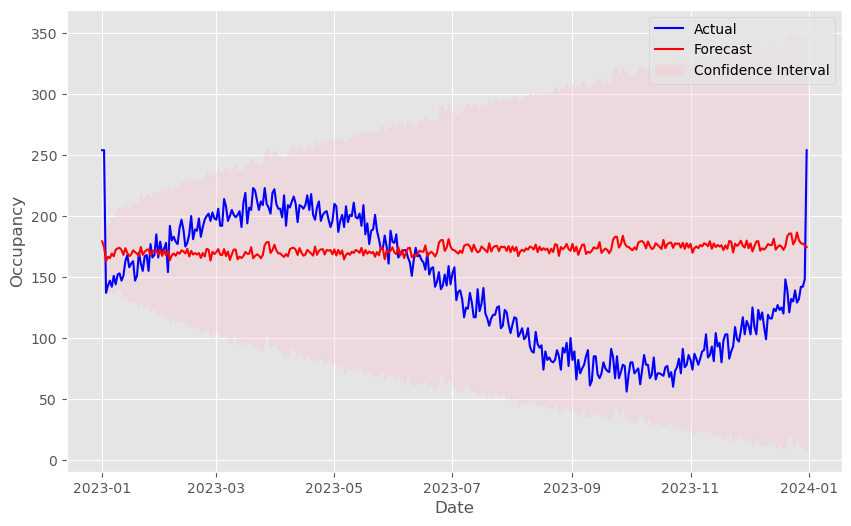

Forecasted values: 2023-01-01    179.216465
2023-01-02    174.640302
2023-01-03    162.995043
2023-01-04    166.661483
2023-01-05    165.420681
                 ...    
2023-12-27    180.233612
2023-12-28    177.717688
2023-12-29    177.389872
2023-12-30    175.888505
2023-12-31    174.572738
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


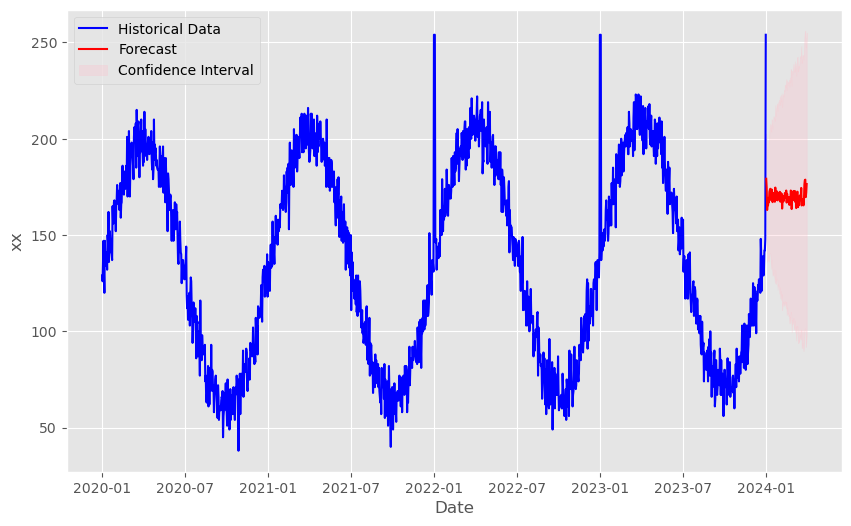

Forecasted values: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x179e10bc0>


In [13]:
# Create a forecast using the SARIMA model for the given time steps
#

# Time steps, days
forecast_steps = 90
forecast_dates = pd.date_range(hotel_time_series_df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

forecast = model_sarima_manual.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#forecast_values, forecast_conf_int = model_fit.predict(n_periods=forecast_steps, return_conf_int=True)


# Plot the historical data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], label='Historical Data', color='blue')
#plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('xx')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')

In [ ]:
# AutoARIMA Forecasting with Plot

# Define the number of steps you want to forecast
forecast_steps = 90  # Forecast the next 10 steps

# Forecast using the trained AutoARIMA model
forecast, conf_int = auto_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a date range for the forecasted values
forecast_dates = pd.date_range(hotel_time_series_df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the historical data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f'Auto SARIMA Forecast for {forecast_steps} Steps')
plt.xlabel('Date')
plt.ylabel('xx')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')


## xxxxxxxxx

In [ ]:
auto_model = pm.auto_arima(
    hotel_time_series_df['Standard_OCC'],           
    start_p=1, max_p=3,         # Range for AR order
    start_q=1, max_q=3,         # Range for MA order
    start_P=0, max_P=2,         # Range for seasonal AR order
    start_Q=0, max_Q=2,         # Range for seasonal MA order
    d=1,                        # Differencing order (can be set to None to auto-detect)
    D=1,                        # Seasonal differencing order (can be set to None to auto-detect)
    m=12,                       # ????? Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search to reduce computation
    trace=True,                 # Print model details during the search
    information_criterion='aic' # Criterion for model selection
)

print(auto_model.summary())